In [97]:
''' Paulo Simplício Braga
    14.07.2020
'''
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams["font.size"] = '12'
plt.rcParams['image.cmap'] = 'rainbow'
import seaborn as sns 

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import warnings
import tensorflow as tf
import keras
import os
seed = 6
import random as rn
rn.seed(seed)

np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
warnings.filterwarnings('ignore')

train_df = pd.read_csv('Data_Titanic/train.csv')

train_df.corr().style.background_gradient().set_precision(2)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1,-0.005,-0.035,0.037,-0.058,-0.0017,0.013
Survived,-0.005,1,-0.34,-0.077,-0.035,0.082,0.26
Pclass,-0.035,-0.34,1,-0.37,0.083,0.018,-0.55
Age,0.037,-0.077,-0.37,1,-0.31,-0.19,0.096
SibSp,-0.058,-0.035,0.083,-0.31,1,0.41,0.16
Parch,-0.0017,0.082,0.018,-0.19,0.41,1,0.22
Fare,0.013,0.26,-0.55,0.096,0.16,0.22,1


I - Cálculo da % de valores faltantes por coluna:

In [2]:
total = train_df.isnull().sum().sort_values(ascending=False)
print(total)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64


In [3]:
pct_1 = train_df.isnull().sum()/train_df.isnull().count()*100
print(pct_1)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [4]:
pct_1 = round(pct_1, 1).sort_values(ascending=False)
print(pct_1)

Cabin          77.1
Age            19.9
Embarked        0.2
Fare            0.0
Ticket          0.0
Parch           0.0
SibSp           0.0
Sex             0.0
Name            0.0
Pclass          0.0
Survived        0.0
PassengerId     0.0
dtype: float64


In [5]:
dados_faltantes = pd.concat([total,pct_1], axis=1, keys=['Total', '%'])
dados_faltantes.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


II - Sobreviventes por sexo

In [6]:
# Quantidade por sexo
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Total')

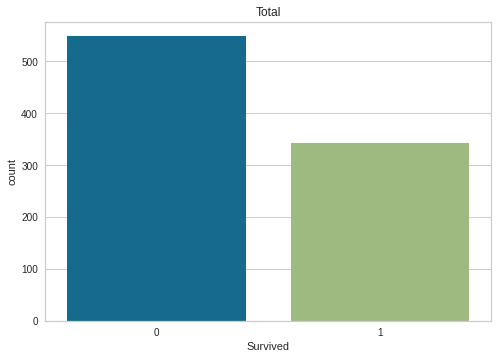

In [7]:
# Total de sobreviventes
sns.countplot(train_df['Survived']).set_title('Total')

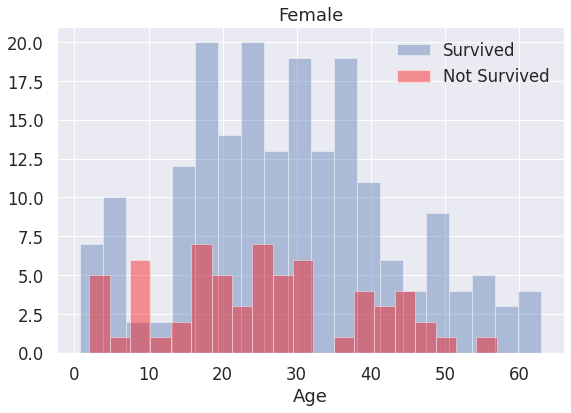

In [8]:
sns.set(font_scale=1.5)
fem = train_df[train_df['Sex']=='female'] # Cria um dataframe para female

# Cria um objeto 'fig' pra fazer o subplot
fig = plt.figure(figsize=(20,6))

# Adiciona o histograma 'Survived'
fig.add_subplot(1,2,1) # linhas, colunas, posição
to_plot = sns.distplot(fem[fem['Survived']==1].Age, bins=20, kde=False,\
                      label='Survived')
to_plot.set_title('Female')
to_plot.legend()

# Adiciona o histograma 'Not Survived'
fig.add_subplot(1,2,1) # linhas, colunas, posição
to_plot = sns.distplot(fem[fem['Survived']==0].Age, bins=20, kde=False,\
             color='red', label='Not Survived')
to_plot.legend()

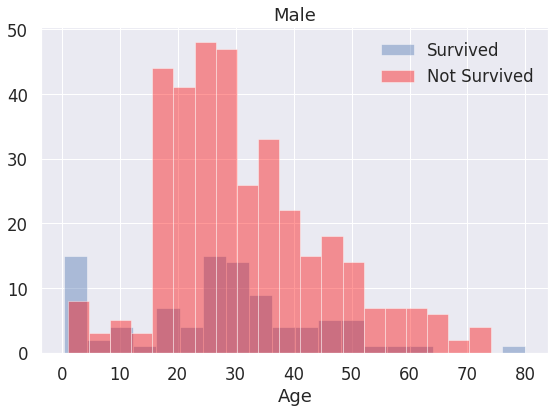

In [9]:
sns.set(font_scale=1.5)
male = train_df[train_df['Sex']=='male'] # Cria um dataframe para male

fig = plt.figure(figsize=(20,6))

fig.add_subplot(1,2,1)
to_plot = sns.distplot(male[male['Survived']==1].Age, bins=20, kde=False,\
                       label='Survived')
to_plot.set_title('Male')
to_plot.legend()

fig.add_subplot(1,2,1)
to_plot = sns.distplot(male[male['Survived']==0].Age, bins=20, kde=False,\
                      color='red', label='Not Survived')
to_plot.legend()


III - Relação da Sobrevivência com Classe Social e Porto de Embarque,
por gênero

Text(0.5, 1.0, 'Survived x Pclass')

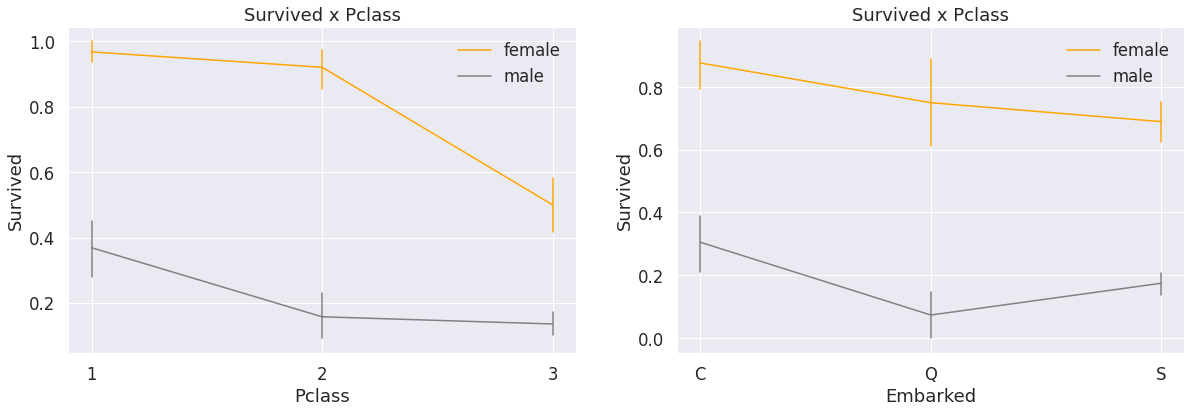

In [10]:
sns.set(font_scale=1.5)
fem = train_df[train_df['Sex']=='female'] # Cria um dataframe para female
male = train_df[train_df['Sex']=='male'] # Cria um dataframe para male

fig = plt.figure(figsize=(20,6))

# Pclass
fig.add_subplot(1,2,1)
to_plot = sns.lineplot('Pclass','Survived',data=fem,err_style="bars",\
                      label='female', color='orange')
fig.add_subplot(1,2,1)
to_plot = sns.lineplot('Pclass','Survived',data=male,err_style="bars",\
                      label='male', color='grey')
to_plot.set_title('Survived x Pclass')
to_plot.set(xticks=(np.arange(1, 4, 1)))

# Embarked
fig.add_subplot(1,2,2)
to_plot = sns.lineplot('Embarked','Survived',data=fem,err_style="bars",\
                      label='female', color='orange')
fig.add_subplot(1,2,2)
to_plot = sns.lineplot('Embarked','Survived',data=male,err_style="bars",\
                      label='male', color='grey')
to_plot.set_title('Survived x Pclass')

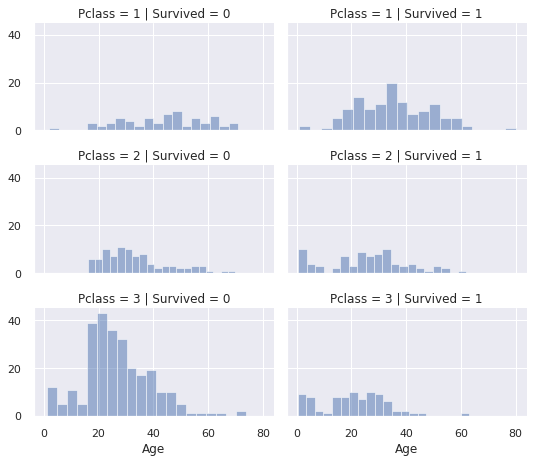

In [11]:
sns.set(font_scale=1.0)
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass',\
                     size=2.2, aspect=1.7)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

IV - Pré-Processamento dos dados

In [12]:
# Remove features como mais de 70% de linhas nulas
limite = 0.7

# train_df = train_df[train_df.columns[train_df.isnull().mean() < limite]]

# Remove Passenger ID, devido a baixa correlação com 'Survived'
train_df = train_df.drop(['PassengerId'], axis = 1)

# # Remove Ticket, devido a baixa correlação com 'Survived'
# train_df = train_df.drop(['Ticket'], axis = 1)

In [13]:
# Cria a variável 'Deck' à partir de 'Cabin'
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

train_df['Cabin'] = train_df['Cabin'].fillna("U0")
train_df['Deck'] = train_df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_df['Deck'] = train_df['Deck'].map(deck)
train_df['Deck'] = train_df['Deck'].fillna(0)
train_df['Deck'] = train_df['Deck'].astype(int) 

In [14]:
train_df = train_df.drop(['Cabin'], axis=1)

In [15]:
num_cols = ['Pclass', 'SibSp', 'Parch', 'Fare']

# Cria o objeto knn para efetuar a imputação de valores baseado 
# no K-Nearest Neighbour (KNN)
knn = KNeighborsClassifier(3, weights='distance')

# Cria um data frame para treinamento do knn, excluindo os valores
# nulos
df_cc = train_df.dropna(axis=0)
df_cc['Age'] = df_cc['Age'].astype(int)

# Treina o modelo com 'Age' como 'target(y)'
model_3nn = knn.fit(df_cc.loc[:,num_cols],\
                    df_cc.loc[:,'Age'])
# Contabiliza a quantidade de nulos da feature 'Age'
missing_age = train_df['Age'].isnull()

# Cria um dataframe com as features 'X' (num_cols) com tamanho 
# igual ao número de valores nulos na feature 'Age'
df_missing_age = pd.DataFrame(train_df[num_cols][missing_age])

# Faz a previsão passando as features 'X', do data frame criado 
# na linha anterior
imputed_age = model_3nn.predict(df_missing_age)

# Preenche os valores nulos da feature 'Age', um por um, com os 
# valores previstos em 'imputed_age'
for i in imputed_age:
    train_df['Age'].fillna(i, inplace=True, limit=1)
train_df['Age'].isnull().sum()

0

In [16]:
# Demonstra que o valor mais comum é o 'S'
print(train_df['Embarked'].describe())
# Apenas dois valores nan
print("Quantidade de Nulos: ",train_df['Embarked'].isnull().sum())

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
Quantidade de Nulos:  2


In [17]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
print("Quantidade de Nulos: ",train_df['Embarked'].isnull().sum())

Quantidade de Nulos:  0


In [18]:
train_df['Fare'] = train_df['Fare'].fillna(0)
train_df['Fare'] = train_df['Fare'].astype(int)

In [19]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

# extraindo os titulos
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# substituir títulos com um título mais comum ou como Rare
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
# converter títulos em números
train_df['Title'] = train_df['Title'].map(titles)
# Inserindo o 0 nos campos NaN 
train_df['Title'] = train_df['Title'].fillna(0)

In [20]:
train_df = train_df.drop(['Name'], axis=1)

In [21]:
# Converte a categoria 'Sex'
genders = {"male": 0, "female": 1}

train_df['Sex'] = train_df['Sex'].map(genders)

In [22]:
# Remove a categoria 'Ticket'
train_df = train_df.drop(['Ticket'], axis=1)

In [23]:
# Converte 'Embarked'
ports = {"S": 0, "C": 1, "Q": 2}
train_df['Embarked'] = train_df['Embarked'].map(ports)

In [24]:
# Converte e agrupa a categoria 'Age'

train_df['Age'] = train_df['Age'].astype(int)
train_df.loc[ train_df['Age'] <= 11, 'Age'] = 0
train_df.loc[(train_df['Age'] > 11) & (train_df['Age'] <= 18), 'Age'] = 1
train_df.loc[(train_df['Age'] > 18) & (train_df['Age'] <= 22), 'Age'] = 2
train_df.loc[(train_df['Age'] > 22) & (train_df['Age'] <= 27), 'Age'] = 3
train_df.loc[(train_df['Age'] > 27) & (train_df['Age'] <= 33), 'Age'] = 4
train_df.loc[(train_df['Age'] > 33) & (train_df['Age'] <= 40), 'Age'] = 5
train_df.loc[(train_df['Age'] > 40) & (train_df['Age'] <= 66), 'Age'] = 6
train_df.loc[ train_df['Age'] > 66, 'Age'] = 6

In [25]:
train_df['Age'].value_counts()

6    167
4    151
3    134
1    133
5    118
2    112
0     76
Name: Age, dtype: int64

In [26]:
# Converte e agrupa 'Fare' com valores adquiridos através da 
# função qcut()

train_df.loc[ train_df['Fare'] <= 7.91, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare'] <= 14.454), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 31), 'Fare']   = 2
train_df.loc[(train_df['Fare'] > 31) & (train_df['Fare'] <= 99), 'Fare']   = 3
train_df.loc[(train_df['Fare'] > 99) & (train_df['Fare'] <= 250), 'Fare']   = 4
train_df.loc[ train_df['Fare'] > 250, 'Fare'] = 5
train_df['Fare'] = train_df['Fare'].astype(int)

In [27]:
# Cria novos parâmetros
train_df['Age_Class']= train_df['Age']* train_df['Pclass']

In [28]:
train_df['relatives'] = train_df['SibSp'] + train_df['Parch']
train_df.loc[train_df['relatives'] > 0, 'not_alone'] = 0
train_df.loc[train_df['relatives'] == 0, 'not_alone'] = 1
train_df['not_alone'] = train_df['not_alone'].astype(int)

In [29]:
train_df['Fare_Per_Person'] = train_df['Fare']/(train_df['relatives']+1)
train_df['Fare_Per_Person'] = train_df['Fare_Per_Person'].astype(int)

In [31]:
# Aplicando Normalization nas features com valores maiores que 1
feat_list = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck',\
             'Title', 'Age_Class', 'relatives', 'Fare_Per_Person']
def normalize(feat, train_df):
    feat_name = 'norm_'+feat    
    train_df[feat_name] = (train_df[feat] - train_df[feat].min())/ \
                    (train_df[feat].max() - train_df[feat].min())
    train_df = train_df.drop(feat, axis=1)
    return train_df
for i in feat_list:
    train_df=normalize(i, train_df)

V - Machine Learning Models

In [73]:
X = train_df.loc[:, train_df.columns != 'Survived'] # X recebe todas as
#, → colunas, exceto a coluna 'quality'
y = train_df.loc[:, train_df.columns == 'Survived'] # y recebe a coluna␣
#, → 'quality'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,\
shuffle = True, stratify = y)
model_list = ['Regressão Logística', 'Classificação Bayseana',\
'Árvore de Decisão', 'Random Forests', 'SVM', 'MLP']
resultados_acur = len(model_list)*[0]
map = {0:"died", 1:"survived"}

1. Regressão Logística

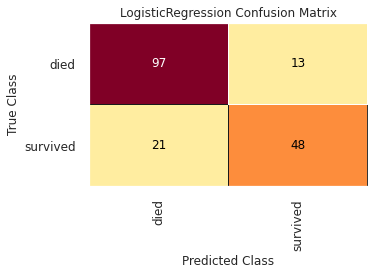

In [74]:
plt.subplots(figsize=(5,3))
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

cm_v = ConfusionMatrix(logreg, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[0] = cm_v.score(X_test, y_test)
cm_v.show()

In [75]:
print(resultados_acur[0])

0.8100558659217877


2. Classificação Bayseana

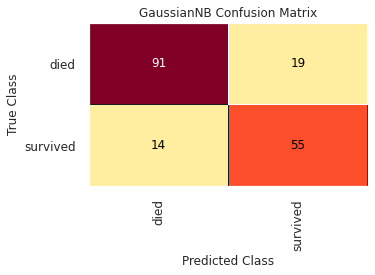

In [76]:
plt.subplots(figsize=(5,3))
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

cm_v = ConfusionMatrix(gaussian, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[1] = cm_v.score(X_test, y_test)
cm_v.show()

In [77]:
resultados_acur[1]

0.8156424581005587

3. Árvore de Decisão

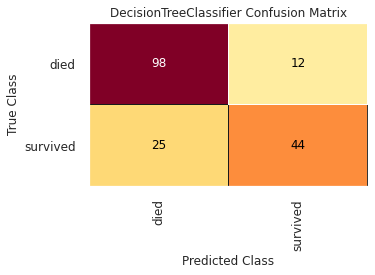

In [78]:
plt.subplots(figsize=(5,3))
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

cm_v = ConfusionMatrix(decision_tree, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[2] = cm_v.score(X_test, y_test)
cm_v.show()

In [79]:
resultados_acur[2]

0.7932960893854749

4. Random Forests

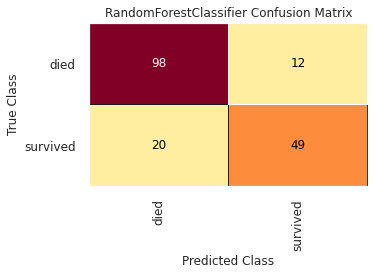

In [80]:
plt.subplots(figsize=(5,3))
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

cm_v = ConfusionMatrix(random_forest, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[3] = cm_v.score(X_test, y_test)
cm_v.show()

In [81]:
print(resultados_acur[3])

0.8212290502793296


5. Support Vector Machine

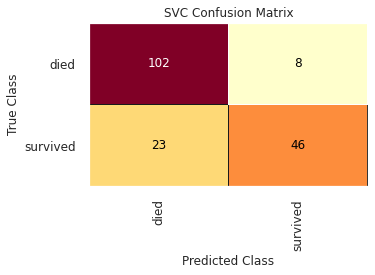

In [82]:
plt.subplots(figsize=(5,3))
svm_model = svm.SVC()#kernel='poly', gamma = 10, degree = 3)
svm_model.fit(X_train, y_train)

cm_v = ConfusionMatrix(svm_model, classes=["died", "survived"], \
                       label_encoder=map)
resultados_acur[4] = cm_v.score(X_test, y_test)
cm_v.show()

In [83]:
resultados_acur[4]

0.8268156424581006

6. MLP

In [84]:
# Função para buscar os melhores valores, baseado na acurácia
def train_mlp_acc(in_p=17, hd_1=5, hd_2=5, output=2, activation='linear', optimizer='adam',\
              train_x=X_train, train_y=y_train, epochs=10):
    # Cria o objeto
    model = keras.models.Sequential()
    
    structure=[in_p,hd_1,hd_2,output]

    # Adiciona o layer de entrada mais o primeiro 'hidden layer'
    model.add(keras.layers.Dense(input_dim=structure[0],\
              units=structure[1], activation=activation))

    # Adiciona o segundo 'hidden layer'
    model.add(keras.layers.Dense(units=structure[2], activation=activation))

    # Adiciona o layer de 'output'
    model.add(keras.layers.Dense(units=structure[-1], activation=\
                                                     "softmax"))
    
    model.compile(loss = 'categorical_crossentropy',\
                  optimizer = optimizer, metrics = ['accuracy'])

    training_stats = model.fit(train_x, train_y, batch_size = 1,\
                               epochs = epochs, verbose = 0, shuffle = False)
    print('Training Evaluation: loss = %0.3f, accuracy = %0.2f%%'
          %(training_stats.history['loss'][-1], 100 * training_stats.\
                                             history['accuracy'][-1]))
    return (100 * training_stats.history['accuracy'][-1])
    

In [85]:
# one-hot encoding
labels=np.array(y_train['Survived'])
y_train = OneHotEncoder(sparse=False).fit_transform(np.transpose([labels]))
print(y_train)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [86]:
X_train.shape

(712, 13)

In [87]:
# Escolhe o melhor valor para os 'hidden layers'
ret_struct = 3*[0]
max_acc = 0
for i in range(1,11):
    print("[hidden layers: %i] " %i, end='')
    acc = train_mlp_acc(in_p=13, hd_1=i, hd_2=i, train_y=y_train)
    if acc > max_acc:
        # Esta rotina grava o melhor valor de i para os 'hidden layers'
        ret_struct[0]=i;
        max_acc=acc

[hidden layers: 1] Training Evaluation: loss = 0.438, accuracy = 80.62%
[hidden layers: 2] Training Evaluation: loss = 0.437, accuracy = 80.06%
[hidden layers: 3] Training Evaluation: loss = 0.434, accuracy = 80.34%
[hidden layers: 4] Training Evaluation: loss = 0.435, accuracy = 80.76%
[hidden layers: 5] Training Evaluation: loss = 0.436, accuracy = 81.04%
[hidden layers: 6] Training Evaluation: loss = 0.436, accuracy = 80.34%
[hidden layers: 7] Training Evaluation: loss = 0.435, accuracy = 80.62%
[hidden layers: 8] Training Evaluation: loss = 0.433, accuracy = 81.18%
[hidden layers: 9] Training Evaluation: loss = 0.437, accuracy = 81.32%
[hidden layers: 10] Training Evaluation: loss = 0.437, accuracy = 81.04%


In [88]:
print("O melhor valor para os 'hidden layers' é:", ret_struct[0])

O melhor valor para os 'hidden layers' é: 9


In [89]:
# Aqui a melhor função de ativação será escolhida baseada em sua acurácia
activation_functions = ['elu', 'selu', 'relu', 'tanh', 'sigmoid', 
                        'hard_sigmoid', 'softplus', 'softsign', 'linear']
max_acc = 0
for activation in activation_functions:
    print("[%s] " %activation, end='')
    acc = train_mlp_acc(in_p=13, activation=activation, train_y=y_train)
    if acc > max_acc:
        # Esta rotina salva a função de ativação com melhor acurácia 
        ret_struct[1]=activation
        max_acc=acc

[elu] Training Evaluation: loss = 0.428, accuracy = 81.88%
[selu] Training Evaluation: loss = 0.435, accuracy = 81.18%
[relu] Training Evaluation: loss = 0.430, accuracy = 81.18%
[tanh] Training Evaluation: loss = 0.423, accuracy = 80.76%
[sigmoid] Training Evaluation: loss = 0.439, accuracy = 80.90%
[hard_sigmoid] Training Evaluation: loss = 0.440, accuracy = 79.78%
[softplus] Training Evaluation: loss = 0.432, accuracy = 80.62%
[softsign] Training Evaluation: loss = 0.417, accuracy = 82.16%
[linear] Training Evaluation: loss = 0.436, accuracy = 80.48%


In [90]:
print("A melhor função de ativação para o modelo é: ", ret_struct[1])

A melhor função de ativação para o modelo é:  softsign


In [91]:
optimization_functions = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta',
                          'Adam', 'Adamax', 'Nadam']
max_acc = 0
for optimizer in optimization_functions:
    print("[%s] " %optimizer, end='')
    acc= train_mlp_acc(in_p=13, optimizer=optimizer, train_y=y_train)
    if acc > max_acc:
        # Esta rotina salva a função de otimização com melhor acurácia 
        ret_struct[2]=optimizer
        max_acc=acc

[SGD] Training Evaluation: loss = 0.440, accuracy = 81.18%
[RMSprop] Training Evaluation: loss = 0.445, accuracy = 80.76%
[Adagrad] Training Evaluation: loss = 0.643, accuracy = 62.78%
[Adadelta] Training Evaluation: loss = 1.165, accuracy = 38.34%
[Adam] Training Evaluation: loss = 0.435, accuracy = 80.90%
[Adamax] Training Evaluation: loss = 0.443, accuracy = 79.78%
[Nadam] Training Evaluation: loss = 0.434, accuracy = 81.04%


In [92]:
print("O melhor otimizador para este modelo é:",ret_struct[2])

O melhor otimizador para este modelo é: SGD


In [93]:
# Função para treinar o modelo 
def train_mlp(model, in_p=17, hd_1=5, hd_2=5, output=2, activation='linear', optimizer='adam',\
              train_x=X_train, train_y=y_train, epochs=10):  
    # Adiciona o layer de entrada mais o primeiro 'hidden layer'
    model.add(keras.layers.Dense(input_dim=in_p,\
              units=hd_2, activation=activation))

    # Adiciona o segundo 'hidden layer'
    model.add(keras.layers.Dense(units=hd_2, activation=activation))

    # Adiciona o layer de 'output'
    model.add(keras.layers.Dense(units=output, activation="softmax"))
    
    model.compile(loss = 'categorical_crossentropy',\
                  optimizer = optimizer, metrics = ['accuracy'])

    training_stats = model.fit(train_x, train_y, batch_size = 1,\
                               epochs = epochs, verbose = 0, shuffle = False)
    print('Training Evaluation: loss = %0.3f, accuracy = %0.2f%%'
          %(training_stats.history['loss'][-1], 100 * training_stats.\
                                             history['accuracy'][-1]))
    return model

In [94]:
print(ret_struct)
model = keras.models.Sequential()

model = train_mlp(model,in_p=13, hd_1=ret_struct[0], hd_2=ret_struct[0], activation=ret_struct[1],\
                  optimizer=ret_struct[2], train_y=y_train)

[9, 'softsign', 'SGD']
Training Evaluation: loss = 0.419, accuracy = 82.16%


In [95]:
# one-hot encoding
labels=np.array(y_test['Survived'])
y_test = OneHotEncoder(sparse=False).fit_transform(np.transpose([labels]))

# Avalia o modelo com os dados dde teste
evaluation = model.evaluate(X_test,y_test, verbose=0)

print('Test Set Evaluation: loss = %0.6f, accuracy = %0.2f' %(evaluation[0], 100*evaluation[1]))

resultados_acur[5] = evaluation[1]

Test Set Evaluation: loss = 0.423659, accuracy = 81.01


7. Acurácia por Modelo

In [96]:
for i in range(len(resultados_acur)):
    print(model_list[i], ":", "{:.2f}".format(resultados_acur[i]*100),"%")

Regressão Logística : 81.01 %
Classificação Bayseana : 81.56 %
Árvore de Decisão : 79.33 %
Random Forests : 82.12 %
SVM : 82.68 %
MLP : 81.01 %
